### 导入数据集
机器学习原始数据集来自Kaggle - NIPS Paper（https://www.kaggle.com/benhamner/nips-papers/home）。

该数据是在Kaggle上NIPS Paper数据集中提供的papers.csv数据集的子集，仅包含了id，year和abstract，其中abstract是由title和abstract组成的。

In [1]:
import pandas as pd
# load the dataset
dataset = pd.read_csv('data/papers2.csv')
dataset.head()

,id,year,abstract1
0,1861,2000,Algorithms for Non-negative Matrix Factorizati...
1,1975,2001,Characterizing Neural Gain Control using Spike...
2,3163,2007,Competition Adds Complexity It is known that d...
3,3164,2007,Efficient Principled Learning of Thin Junction...
4,3167,2007,Regularized Boost for Semi-Supervised Learning...


### 初步文本探索
#### 获取每个摘要的字数

In [2]:
dataset['word_count'] = dataset['abstract1'].apply(lambda x: len(str(x).split(" ")))
dataset[['abstract1', 'word_count']].head()

,abstract1,word_count
0,Algorithms for Non-negative Matrix Factorizati...,112
1,Characterizing Neural Gain Control using Spike...,88
2,Competition Adds Complexity It is known that d...,70
3,Efficient Principled Learning of Thin Junction...,150
4,Regularized Boost for Semi-Supervised Learning...,124


#### 获取字数综合统计

In [3]:
dataset.word_count.describe()

count    3924.000000
mean      155.888124
std        46.001025
min        27.000000
25%       122.000000
50%       151.000000
75%       185.000000
max       325.000000
Name: word_count, dtype: float64

每个摘要的平均字数约为156个字。单词计数范围从最小值27到最大值325.单词计数对于向我们指示我们正在处理的数据集的大小以及跨行的单词计数的变化非常重要。

#### 统计最常见词和最不常见的词

浏览一下最常用的单词，不仅可以洞察经常使用的单词，还可以洞察可能是特定于数据的潜在停止词的单词。比较最常用的单词和默认的英语停止词，我们将得到需要添加到自定义停止词列表中的单词列表。

In [4]:
# Identify common words
freq = pd.Series(' '.join(dataset['abstract1']).split()).value_counts()[:20]
freq

the         30107
of          21685
a           16518
and         14218
to          13104
in           9454
for          8382
that         7841
is           7687
We           6239
on           5704
we           5167
with         5142
as           3686
this         3677
are          3546
an           3398
by           3302
can          2958
learning     2903
dtype: int64

In [5]:
# #Identify uncommon words
freq1 = pd.Series(' '.join(dataset['abstract1']).split()).value_counts()[-20:]
freq1

rotation-in-depth                              1
28.57%                                         1
triplets,                                      1
(STP)                                          1
matrix).We                                     1
Indoor                                         1
coevolutionary                                 1
k-space,                                       1
\name\                                         1
$O(\log^2                                      1
alternate,                                     1
inaccurate.                                    1
rodents                                        1
https://github.com/jiasenlu/visDial.pytorch    1
high-stakes                                    1
quarters,                                      1
winner-less                                    1
approximately)                                 1
(linContextual),                               1
wecan                                          1
dtype: int64

### 文字预处理
#### 文本预处理的目标：
> 稀疏性：在文本挖掘中，基于词频创建巨大的矩阵，其中许多单元具有零值。这个问题被称为稀疏性，并使用各种技术最小化。

#### 组成
文本预处理可分为两大类- 噪声消除和归一化，可见下图。
![文本预处理流程](https://github.com/vancuicide/keyword_extraction/blob/master/nips/text_preprocess.jpeg?raw=true "文本预处理流程")
* 对核心文本分析而言冗余的数据组件可视为噪声。
* 处理同一个单词的多个出现/表示称为标准化。标准化有两种类型 - 词干提取和词形还原。让我们考虑一下 learn 这个词的各种版本的例子 - learn, learned, learning, learner。标准化会将这些单词转换为单个标准化版本 - "learn"。

In [9]:
# 举一个例子，说明词干和lemmatisation的工作方式
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:", stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: invers
lemmatization: inversely


#### 接下来对数据集进行文本预处理，首先导入需要的Python库

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

删除停用词（stopwords）：停止词包括句子中的大量介词，代词，连词等。在分析文本之前，需要删除这些单词，以便经常使用的单词主要是与上下文相关的单词，而不是文本中使用的常用单词。

python nltk库中有一个默认的停止词列表。此外，我们可能希望添加特定于上下文的停止词，我们在开头列出的“最常用词”对此有用。

In [11]:
# Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
# Creating a list of custom stopwords
news_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(news_words)

#### 逐步进行数据预处理任务，以获得清理和归一化的文本语料库

In [12]:
corpus = []
for i in range(0, 3924):
    # remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['abstract1'][i])
    
    # convert to lowercase
    text = text.lower()
    
    # remove tags
    text = re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text = re.sub("(\d|\W)+"," ",text)
    
    # convert to list from string
    text = text.split()
    
    # stemming
    ps = PorterStemmer()
    # lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    corpus.append(text)

In [13]:
corpus[222]

'temporal difference based actor critic learning convergence neural implementation actor critic algorithm reinforcement learning achieving renewed popularity due good convergence property situation approach often fail e g function approximation involved interestingly growing evidence actor critic approach based phasic dopamine signal play key role biological learning cortical basal ganglion derive temporal difference based actor critic learning algorithm convergence proved without assuming separate time scale actor critic approach demonstrated applying network spiking neuron established relation phasic dopamine temporal difference signal lends support biological relevance algorithm'

### 数据探索
可视化我们在预处理后创建的文本语料库，以获得对最常用单词的分析。

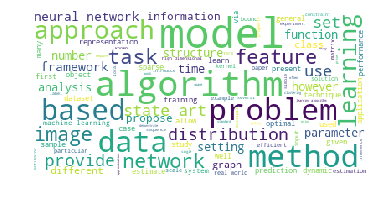

In [16]:
# word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

wordcloud = WordCloud(background_color='white',
                     stopwords=stop_words,
                     max_words=100,
                     max_font_size=50,
                     random_state=42).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

### 文本准备
语料库中的文本需要转换为可由机器学习算法解释的格式。这种转换有两部分 - 标记化和矢量化。
> * 标记化是将连续文本转换为单词列表的过程。
* 然后通过矢量化过程将单词列表转换为整数矩阵。矢量化也称为特征提取。

对于文本准备，我们使用bag of words模型，它忽略了单词的顺序，只考虑单词频率。

创建单词计数向量

作为转换的第一步，我们将使用CountVectoriser来标记文本并构建已知单词的词汇表。我们首先创建CountVectoriser类的变量“cv”，然后调用fit_transform函数来学习和构建词汇表。

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv = CountVectorizer(max_df=0.8, stop_words=stop_words, max_features=10000, ngram_range=(1, 3))
X = cv.fit_transform(corpus)

现在让我们了解传递给函数的参数：

cv = CountVectorizer（max_df = 0.8，stop_words = stop_words，max_features = 10000，ngram_range =（1,3））
> * max_df - 构建词汇表时，忽略文档频率严格高于给定阈值的项（语料库特定的停止词）。这是为了确保我们只有与上下文相关的单词而不是常用单词。
* max_features - 确定矩阵中的列数。
* n-gram范围 - 我们希望查看单个单词，两个单词（bi-gram）和三个单词（tri-gram）组合的列表。

返回具有整个词汇长度的编码向量。

In [18]:
list(cv.vocabulary_.keys())[:10]

['algorithm',
 'non',
 'negative',
 'matrix',
 'factorization',
 'nmf',
 'useful',
 'decomposition',
 'multivariate',
 'data']

### 可视化前N个uni-grams, bi-grams, tri-grams
我们可以使用CountVectorizer来显示前20个unigrams，bi-gram和tri-gram。

/home/wy/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0,'model'),
 Text(0,0,'algorithm'),
 Text(0,0,'learning'),
 Text(0,0,'method'),
 Text(0,0,'problem'),
 Text(0,0,'data'),
 Text(0,0,'network'),
 Text(0,0,'approach'),
 Text(0,0,'function'),
 Text(0,0,'based'),
 Text(0,0,'time'),
 Text(0,0,'paper'),
 Text(0,0,'task'),
 Text(0,0,'result'),
 Text(0,0,'distribution'),
 Text(0,0,'feature'),
 Text(0,0,'propose'),
 Text(0,0,'image'),
 Text(0,0,'state'),
 Text(0,0,'inference')]

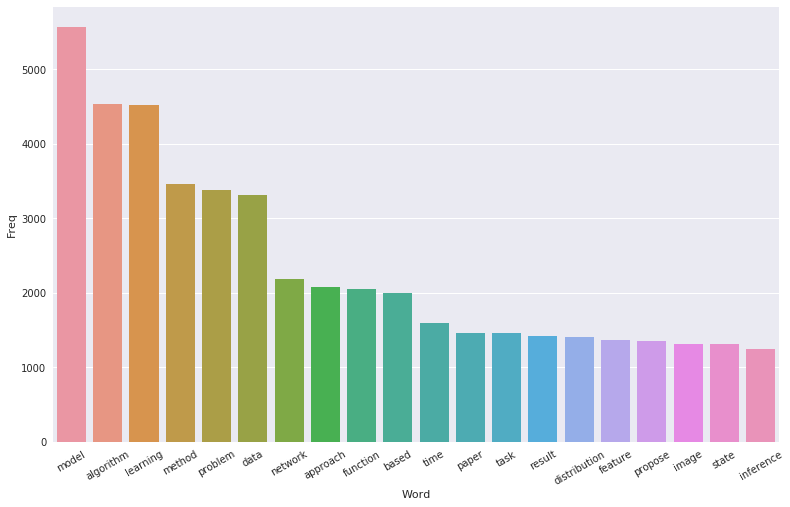

In [21]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                   Bi-gram  Freq
0                state art   718
1           neural network   690
2         machine learning   428
3               real world   380
4         high dimensional   375
5       learning algorithm   358
6          graphical model   286
7   reinforcement learning   276
8              lower bound   272
9         gaussian process   264
10                data set   239
11                low rank   238
12           paper propose   237
13    optimization problem   230
14     experimental result   220
15           loss function   215
16        gradient descent   212
17             monte carlo   208
18     stochastic gradient   204
19        generative model   193


/home/wy/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0,'state art'),
 Text(0,0,'neural network'),
 Text(0,0,'machine learning'),
 Text(0,0,'real world'),
 Text(0,0,'high dimensional'),
 Text(0,0,'learning algorithm'),
 Text(0,0,'graphical model'),
 Text(0,0,'reinforcement learning'),
 Text(0,0,'lower bound'),
 Text(0,0,'gaussian process'),
 Text(0,0,'data set'),
 Text(0,0,'low rank'),
 Text(0,0,'paper propose'),
 Text(0,0,'optimization problem'),
 Text(0,0,'experimental result'),
 Text(0,0,'loss function'),
 Text(0,0,'gradient descent'),
 Text(0,0,'monte carlo'),
 Text(0,0,'stochastic gradient'),
 Text(0,0,'generative model')]

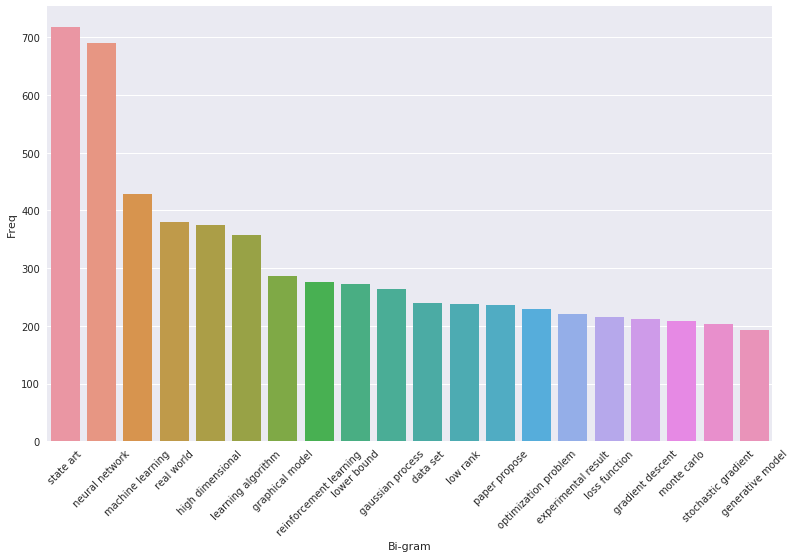

In [22]:
# Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), 
                           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                        Tri-gram  Freq
0            deep neural network   121
1   convolutional neural network   120
2       recurrent neural network    96
3    stochastic gradient descent    95
4          state art performance    82
5       semi supervised learning    77
6        markov decision process    77
7            real world datasets    76
8             multi armed bandit    76
9                low rank matrix    75
10         latent variable model    74
11              state art method    73
12               real world data    68
13          synthetic real world    62
14         outperforms state art    60
15              state art result    60
16  principal component analysis    59
17            markov chain monte    59
18             chain monte carlo    59
19   empirical risk minimization    58


/home/wy/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0,'deep neural network'),
 Text(0,0,'convolutional neural network'),
 Text(0,0,'recurrent neural network'),
 Text(0,0,'stochastic gradient descent'),
 Text(0,0,'state art performance'),
 Text(0,0,'semi supervised learning'),
 Text(0,0,'markov decision process'),
 Text(0,0,'real world datasets'),
 Text(0,0,'multi armed bandit'),
 Text(0,0,'low rank matrix'),
 Text(0,0,'latent variable model'),
 Text(0,0,'state art method'),
 Text(0,0,'real world data'),
 Text(0,0,'synthetic real world'),
 Text(0,0,'outperforms state art'),
 Text(0,0,'state art result'),
 Text(0,0,'principal component analysis'),
 Text(0,0,'markov chain monte'),
 Text(0,0,'chain monte carlo'),
 Text(0,0,'empirical risk minimization')]

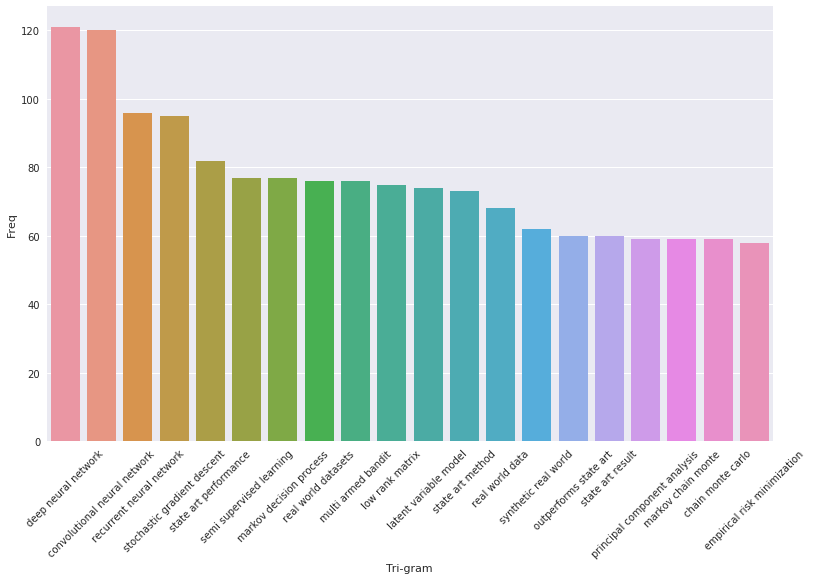

In [24]:
# Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec2 = CountVectorizer(ngram_range=(3,3), 
                           max_features=2000).fit(corpus)
    bag_of_words = vec2.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec2.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

### 转换为整数矩阵
细化单词计数的下一步是使用TF-IDF向量化器。从countVectorizer获得的单词计数的不足之处在于，大量的某些常用单词可能会稀释语料库中更多上下文特定单词的影响。这被TF-IDF矢量化器克服，该矢量化器惩罚在整个文档中出现若干次的单词。TF-IDF是词频分数，它突出显示对上下文更重要的单词，而不是那些在文档中频繁出现的单词。

TF-IDF由2个组成部分组成：
> * TF - TF意思是词频(Term Frequency)
* IDF - IDF意思是逆文本频率指数(Inverse Document Frequency)



In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X)

# get feature name
feature_names = cv.get_feature_names()

# fetech document for which keywords nees to be extracted
doc = corpus[532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

### 根据TF-IDF分数，我们可以提取分数最高的单词来获取文档的关键字

In [29]:
# Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
 
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
 
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    # results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
 
    return results

# sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
# extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
compositionality optimal control law present theory compositionality stochastic optimal control showing task optimal controller constructed certain primitive primitive feedback controller pursuing agenda mixed proportion much progress making towards agenda compatible agenda present task resulting composite control law provably optimal problem belongs certain class class rather general yet number unique property bellman equation made linear even non linear discrete dynamic give rise compositionality developed special case linear dynamic gaussian noise framework yield analytical solution e non linear mixture linear quadratic regulator without requiring final cost quadratic generally natural set control primitive constructed applying svd green function bellman equation illustrate theory context human arm movement idea optimality compositionality prominent field motor control yet hard reconcile work make possible

Keywords:
compositionality 0.395
control 0.292
primitive 0.269
li